# Hospital Example

In [33]:
import numpy as np
import pandas
import IPython.display
import ipywidgets

import raha

## 1. Instantiating the Detection and Correction Classes

In [34]:
from raha import analysis_utilities
app_1 = raha.Detection()
app_2 = raha.Correction()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20
app_2.LABELING_BUDGET = 0

# Would you like to see the logs?
app_1.VERBOSE = True
app_2.VERBOSE = True

## 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [35]:
dataset_dictionary = {
        "name": "hospital",
        "path": "datasets/hospital/dirty.csv",
        "clean_path": "datasets/hospital/clean.csv"
    }
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,index,provider_number,name,address_1,address_2,address_3,city,state,zip,county,phone,type,owner,emergency_service,condition,measure_code,measure_name,score,sample,state_average
0,1,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-card-2,surgery patients who were taking heart drugs c...,empty,empty,al_scip-card-2
1,2,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-1,surgery patients who were given an antibiotic ...,empty,empty,al_scip-inf-1
2,3,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-2,surgery patients who were given the right kind...,empty,empty,al_scip-inf-2
3,4,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birminghxm,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-3,surgery patients whose preventive antibiotics ...,empty,empty,al_scip-inf-3
4,5,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-4,all heart surgery patients whose blood sugar (...,empty,empty,al_scip-inf-4


## 3. Generating Features and Clusters

In [36]:
app_1.run_strategies(d)
app_1.generate_features(d)
app_1.build_clusters(d)

I just load strategies' results as they have already been run on the dataset!


776 strategy profiles are collected.
54 Features are generated for column 0.
77 Features are generated for column 1.
61 Features are generated for column 2.
71 Features are generated for column 3.
0 Features are generated for column 4.
0 Features are generated for column 5.
65 Features are generated for column 6.
47 Features are generated for column 7.
77 Features are generated for column 8.
72 Features are generated for column 9.
76 Features are generated for column 10.
68 Features are generated for column 11.
57 Features are generated for column 12.
48 Features are generated for column 13.
62 Features are generated for column 14.
68 Features are generated for column 15.
73 Features are generated for column 16.
69 Features are generated for column 17.
71 Features are generated for column 18.
71 Features are generated for column 19.
A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for 

## 4. Interactive Tuple Sampling and Labeling

In [37]:
%%capture
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)

## 5. Propagating User Labels and Predicting the Labels

In [38]:
app_1.propagate_labels(d)
app_1.predict_labels(d)

The number of labeled data cells increased from 400 to 15994.
A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.
A classifier is trained and applied on column 7.
A classifier is trained and applied on column 8.
A classifier is trained and applied on column 9.
A classifier is trained and applied on column 10.
A classifier is trained and applied on column 11.
A classifier is trained and applied on column 12.
A classifier is trained and applied on column 13.
A classifier is trained and applied on column 14.
A classifier is trained and applied on column 15.
A classifier is trained and applied on column 16.
A classifier is trained and applied on column 17.
A classifier is trained and applied on column 18

## 6. Initializing and Updating the Error Corrector Models

In [39]:
app_2.initialize_models(d)
app_2.initialize_dataset(d)
for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are initialized.
The error corrector models are updated with new labeled tuple 187.
19074 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 1: Train
    Column 7: Train
    Column 8: Train
    Column 9: Train
    Column 11: No train 1
    Column 12: Train
    Column 14: Train
    Column 15: Train
    Column 16: Train
    Column 17: Train
    Column 18: Train
    Column 19: Train
Train sizes in this step:
    Column 1: 45
    Column 7: 2
    Column 8: 44
    Column 9: 80
    Column 11: 4
    Column 12: 28
    Column 14: 12
    Column 15: 31
    Column 16: 84
    Column 17: 54
    Column 18: 300
    Column 19: 49
Corrections applied in this step:
    Column 1: 20 Real changes: 20
    Column 7: 24 Real changes: 24
    Column 8: 28 Real changes: 28
    Column 9: 23 Real changes: 23
    Column 11: 28 Real changes: 28
    Column 12: 7 Real changes: 7
    Column 14: 14 Real changes: 14
    Column 15: 22 Real c

## 8. Evaluating the Data Cleaning Task

In [40]:
edp, edr, edf = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
ecp, ecr, ecf = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]

evaluation_df = pandas.DataFrame(columns=["Task", "Precision", "Recall", "F1 Score"])
evaluation_df = evaluation_df.append({"Task": "Error Detection (Raha)", "Precision": "{:.2f}".format(edp), 
                                      "Recall": "{:.2f}".format(edr), "F1 Score": "{:.2f}".format(edf)}, ignore_index=True)
evaluation_df = evaluation_df.append({"Task": "Error Correction (Baran)", "Precision": "{:.2f}".format(ecp), 
                                      "Recall": "{:.2f}".format(ecr), "F1 Score": "{:.2f}".format(ecf)}, ignore_index=True)
evaluation_df.head()

/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


,Task,Precision,Recall,F1 Score
0,Error Detection (Raha),0.95,0.60,0.74
1,Error Correction (Baran),0.88,0.43,0.58


## Analyze the alternative repairs

In [41]:
number_of_repairs = len(d.correction_collection)
number_of_repairs_hist = dict()

for cell_repairs in d.correction_collection.values():
    num = len(cell_repairs)
    number_of_repairs_hist[num] = number_of_repairs_hist.get(num, 0) + 1

hist = [0] * (max(number_of_repairs_hist.keys()) + 1)
for num, count in number_of_repairs_hist.items():
    hist[num] = count

f"Histogram of the number of alternative repairs: {list(enumerate(hist))}"

'Histogram of the number of alternative repairs: [(0, 0), (1, 190), (2, 24), (3, 10), (4, 2), (5, 3)]'

In [42]:
diff_collection = []

for corrections in d.correction_collection.values():
    if len(corrections) > 1:
        probabilities = list(sorted(corrections.values(), reverse=True))
        diffs = [a - b for a, b in zip(probabilities[:-1], probabilities[1:])]
        diff_collection.append(diffs)

In [43]:
first_diff_collection = [l[0] for l in diff_collection]

np.histogram(first_diff_collection,np.linspace(0.0,0.5,101))

(array([39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
        0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
        0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
        0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.3

In [44]:
second_probs = []

for corrections in d.correction_collection.values():
    if len(corrections) > 1:
        second_probability = list(sorted(corrections.values(), reverse=True))[1]
        second_probs.append(second_probability)

np.histogram(second_probs,np.linspace(0.5,1.0,101))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 39]),
 array([0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
        0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
        0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
        0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
        0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 ,
        0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
        0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 ,
        0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.8

In [45]:
correct_repairs = d.get_actual_errors_dictionary()
error_repaired_cells = [cell for cell, correction in d.corrected_cells.items() if cell in correct_repairs and correction != correct_repairs[cell]]

In [46]:
f"Number of incorrectly repaired cells: {len(error_repaired_cells)}"

'Number of incorrectly repaired cells: 29'

In [47]:
correct_repair_available = 0

for cell in error_repaired_cells:
    if correct_repairs[cell] in d.correction_collection[cell].keys():
        correct_repair_available += 1

f"Number of incorrectly repaired cells, where the correct repair is among the alternative repairs: {correct_repair_available}"

'Number of incorrectly repaired cells, where the correct repair is among the alternative repairs: 20'

In [48]:
correct_repair_probs = []

for cell in error_repaired_cells:
    if correct_repairs[cell] in d.correction_collection[cell]:
        correct_repair_probs.append(d.correction_collection[cell][correct_repairs[cell]])

np.histogram(correct_repair_probs,np.linspace(0.5,1.0,101))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20]),
 array([0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
        0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
        0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
        0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
        0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 ,
        0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
        0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 ,
        0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.8

## Analyze confidence vs error probability

In [49]:
import importlib
from raha import analysis_utilities
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.ion()

In [56]:
importlib.reload(analysis_utilities)

<module 'raha.analysis_utilities' from '/home/adrian/source/MA/raha/raha/analysis_utilities.py'>

In [51]:
repair_confidence_df = analysis_utilities.get_correction_confidence_df(d)

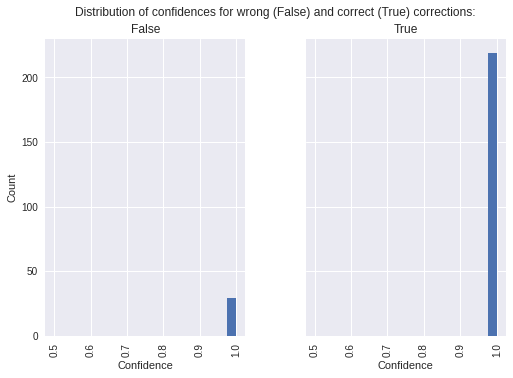

In [52]:
analysis_utilities.correction_confidence_distributions(repair_confidence_df)

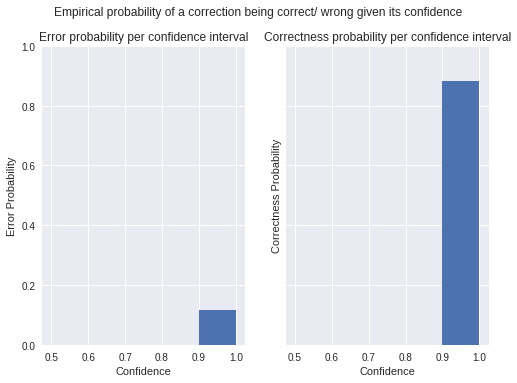

In [53]:
analysis_utilities.correction_correctness_by_confidence(repair_confidence_df)

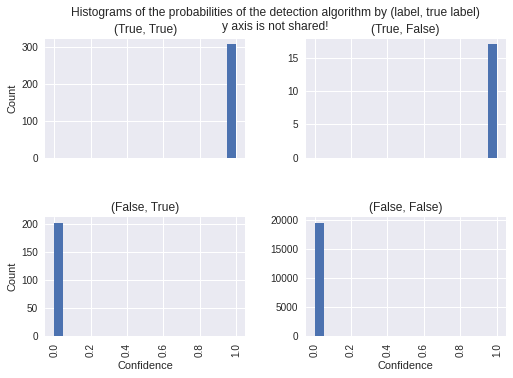

In [57]:
analysis_utilities.detection_evaluation(d)

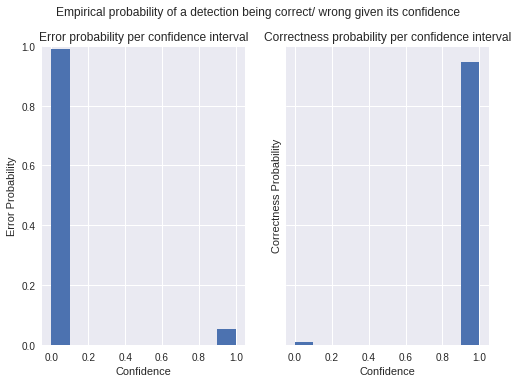

In [58]:
analysis_utilities.detection_correctness_by_confidence(d,number_of_bins=10)